In [35]:
!pip install -q -U kaggle_environments


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [36]:
import numpy as np
import pandas as pd
import random
import math

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate


Добавляем агента, который выбирает только камень.

In [37]:
class RockAgent:
    def __call__(self, observation, configuration):
        # 0 - камень
        return 0

Добавляем агента, который выбирает только бумагу.

In [38]:

class PaperAgent:
    def __call__(self, observation, configuration):
        # 1 - бумага
        return 1

Добавляем агента, который выбирает только ножницы.

In [39]:
class ScissorsAgent:
    def __call__(self, observation, configuration):
        # 2 - ножницы
        return 2
     

Добавляем агента, который производит то же самое действие, что и оппонент на прошлом ходу.

In [40]:
class CopyAgent:
    def __call__(self, observation, configuration):
        # если это не первый ход
        if observation.step > 0:
            # то ходим так, как ходил соперник в прошлый ход
            return observation.lastOpponentAction
        # иначе это первый ход
        else:
            # возвращаем рандомное значение из доступных вариантов
            return random.randrange(0, configuration.signs)

Добавляем агента, реагирующего на последний ход соперника. Данный агент выбирает ход, с которым он бы победил в предыдущем раунде.

In [41]:
class ReactionaryAgent:
    def __call__(self, observation, configuration):
        # если это первый ход
        if observation.step == 0:
            # возвращаем рандомное значение из доступных вариантов
            return random.randrange(0, configuration.signs)
        # берем предыдущий ход соперника и ходим, чтобы победить его
        return (observation.lastOpponentAction + 1) % configuration.signs

Добавляем агента, реагирующего на последний ход соперника. Данный агент выбирает ход, с которым он бы победил в игре против предыдущего агента(reactionary_agent)

In [42]:

class ContrReactionaryAgent:
    # инициализируем агента
    def __init__(self):
        # инициализируем переменную, в которой будем хранить свой последний ход
        self.last_step = -1

    def __call__(self, observation, configuration):
        # если это первый ход
        if self.last_step < 0:
            # записываем в переменную последнего хода 0
            self.last_step = 0
        # иначе
        else:
            # записываем в переменную последнего хода значение на 2 больше,
            # чем последний ход соперника
            self.last_step = (self.last_step + 2) % configuration.signs
        # возвращаем получившееся значение
        return self.last_step

Добавляем монотонного агента, который ходит по порядку меняя ход на следующий (0-1-2-0-1-2-...).

In [43]:
class MonotonousAgent:
    def __call__(self, observation, configuration):
        # если это первый ход
        if observation.step == 0:
            # возвращаем рандомное значение из доступных вариантов
            return random.randrange(0, configuration.signs)
        # иначе берем остаток от деления номера текущего эпизода на
        # количество возможных вариантов
        return observation.step % configuration.signs

Добавляем статистического агента, который подсчитывает самый частый ход соперника и соответственно реагирует.

In [44]:
class StatisticalAgent:
    def __init__(self):
        # инициализируем переменную для хранения статистики
        self.action_histogram = {}

    def __call__(self, observation, configuration):
        # если это первый ход
        if observation.step == 0:
            # сбрасываем статистику
            self.action_histogram = {}
            # возвращаем рандомное значение из доступных вариантов
            return random.randrange(0, configuration.signs)
        # сохраняем в переменную последний ход соперника
        action = observation.lastOpponentAction
        # если такого ключа еще нет в справочнике
        if action not in self.action_histogram:
            # добавляем в справочник со значением 0
            self.action_histogram[action] = 0
        # делаем инкремент счетчика для такого хода соперника
        self.action_histogram[action] += 1

        # определяем статистически самый частый ход соперника
        # инициализируем переменную для хранения хода с максимальным счетчиком
        mode_action = None
        # инициализируем переменную для хранения максимального значения счетчика
        mode_action_count = None
        # для каждой пары ключ-значение в справочнике статистики
        for k, v in self.action_histogram.items():
            # если значение в справочнике для этого ключа не установлено
            # или значение итератора больше значения в справочнике
            if mode_action_count is None or v > mode_action_count:
                # сохраняем текущий ключ в переменную максимума
                mode_action = k
                # сохраняем текущее значение в переменную максимума
                mode_action_count = v
                # переходим к следующей итерации
                continue
        # ходим так, чтобы победить самый частый ход соперника
        return (mode_action + 1) % configuration.signs

Добавляем агента, который ходит всегда случайно.

In [45]:
class RandomChoiceAgent:
    def __call__(self, observation, configuration):
        # возвращаем рандомное значение из доступных вариантов
        return random.randrange(0, configuration.signs)
     

Добавляем агента, который ходит монотонно, но через один шаг (0-2-1-0-2-1...)

In [46]:
class MonotonousStepAgent:
    def __init__(self):
        # инициализируем поле для хранения последнего хода
        self.last_step = -1

    def __call__(self, observation, configuration):
        # если это первый ход
        if self.last_step < 0:
            # возвращаем рандомное значение из доступных вариантов
            self.last_step = random.randrange(0, configuration.signs)
        # прибавляем 2 к своему последнему ходу
        return (self.last_step + 2) % configuration.signs


Добавляем агента, который ходит монотонно, но повторяет по 2 раза (0-0-1-1-2-2-0...)

In [47]:
class MonotonousRepeatAgent:
    def __init__(self):
        # инициализируем поле для хранения последнего хода
        self.last_step = -1
        # инициализируем поле для хранения  количества повторов
        self.repeats = 0

    def __call__(self, observation, configuration):
        # если это первый ход
        if self.last_step < 0:
            # возвращаем рандомное значение из доступных вариантов
            self.last_step = random.randrange(0, configuration.signs)
        # если повтора еще не было
        if self.repeats == 0:
            # инкрементируем количество повторов
            self.repeats += 1
        # если уже повторяли
        else:
            # сбрасываем счетчик повторов
            self.repeats = 0
            # инкрементируем значение последнего шага
            self.last_step = (self.last_step + 1) % configuration.signs
        # возвращаем значение поля, хранящего последний шаг
        return self.last_step


Добавляем агента, который 1/3 предусмотренных эпизодов ходит 0, затем еще 1/3 ходит 1, потом оставшуюся часть ходит 2

In [48]:
class PartAgent:
    def __init__(self):
        # инициализируем поле для хранения последнего хода
        self.last_step = 0
        # инициализируем поле для хранения  количества повторов
        self.repeats = 0

    def __call__(self, observation, configuration):
        # если количество повторов меньше 1/3 от запланированного количества эпизодов
        if self.repeats < (configuration.get('episodeSteps') / 3):
            # инкрементируем счетчик повторов
            self.repeats += 1
        # иначе переход к следующему значению
        else:
            # сбрасываем счетчик повторов
            self.repeats = 0
            # инкрементируем значение последнего шага
            self.last_step = (self.last_step + 1) % configuration.signs
        # возвращаем значение поля, хранящего последний шаг
        return self.last_step

Добавляем агента, который 1/3 предусмотренных эпизодов, ходит как ReactionaryAgent, а затем как StatisticalAgent

In [49]:
class ComboAgent:
    def __init__(self):
        # инициализируем поле для хранения последнего хода
        self.last_step = 0
        # инициализируем поле для хранения  количества повторов
        self.repeats = 0
        # инициализируем переменную для хранения статистики
        self.action_histogram = {}

    def __call__(self, observation, configuration):
        # если это первый ход
        if observation.step == 0:
            # сбрасываем статистику
            self.action_histogram = {}
            # возвращаем рандомное значение из доступных вариантов
            return random.randrange(0, configuration.signs)
        # сохраняем в переменную последний ход соперника
        action = observation.lastOpponentAction
        # если количество повторов меньше 1/3 от запланированного количества эпизодов
        if self.repeats < (configuration.get('episodeSteps') / 3):
            # инкрементируем счетчик повторов
            self.repeats += 1
            # берем предыдущий ход соперника и ходим, чтобы победить его
            return (action + 1) % configuration.signs
        # иначе после прохождения 1/3 эпизодов
        else:
            # если такого ключа еще нет в справочнике
            if action not in self.action_histogram:
                # добавляем в справочник со значением 0
                self.action_histogram[action] = 0
            # делаем инкремент счетчика для такого хода соперника
            self.action_histogram[action] += 1

            # определяем статистически самый частый ход соперника
            # инициализируем переменную для хранения хода с максимальным счетчиком
            mode_action = None
            # инициализируем переменную для хранения максимального значения счетчика
            mode_action_count = None
            # для каждой пары ключ-значение в справочнике статистики
            for k, v in self.action_histogram.items():
                # если значение в справочнике для этого ключа не установлено
                # или значение итератора больше значения в справочнике
                if mode_action_count is None or v > mode_action_count:
                    # сохраняем текущий ключ в переменную максимума
                    mode_action = k
                    # сохраняем текущее значение в переменную максимума
                    mode_action_count = v
                    # переходим к следующей итерации
                    continue
            # ходим так, чтобы победить самый частый ход соперника
            return (mode_action + 1) % configuration.signs

Собираем справочник агентов, где ключ - наименование, а значение - инстанс соответствующего агента

In [50]:
agents = {
    'rock': RockAgent(),
    'paper': PaperAgent(),
    'scissors': ScissorsAgent(),
    'copy_opponent': CopyAgent(),
    'reactionary': ReactionaryAgent(),
    'contr_reactionary': ContrReactionaryAgent(),
    'monotonous': MonotonousAgent(),
    'statistical': StatisticalAgent(),
    'random_choice': RandomChoiceAgent(),
    'monotonous_step': MonotonousStepAgent(),
    'repeat': MonotonousRepeatAgent(),
    'part': PartAgent(),
    'combo': ComboAgent()
}

Проводим Турнир в 2-х разрезах:

За победу в матче присуждаем 2 очка, за ничью - 1
Считаем сумму по выигранным/проигранным эпизодам - за победу в эпизоде +1, за поражение -1

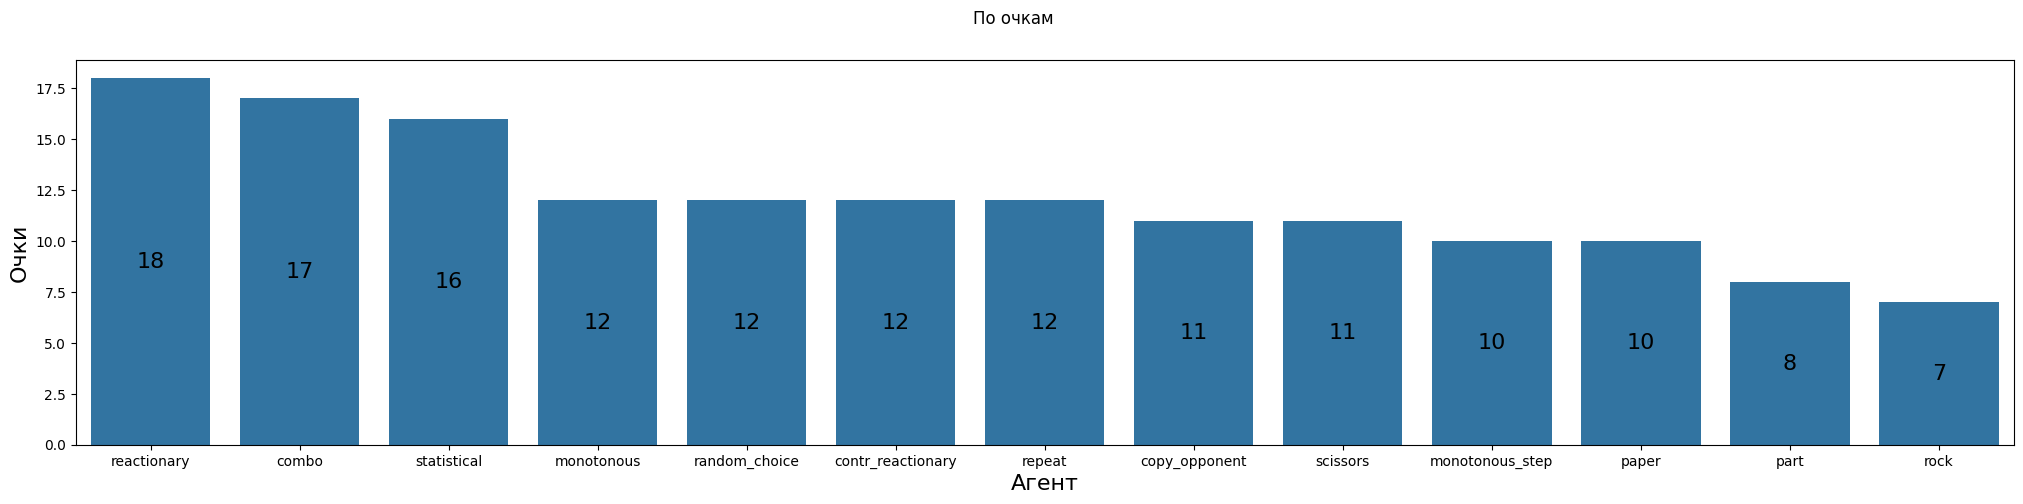

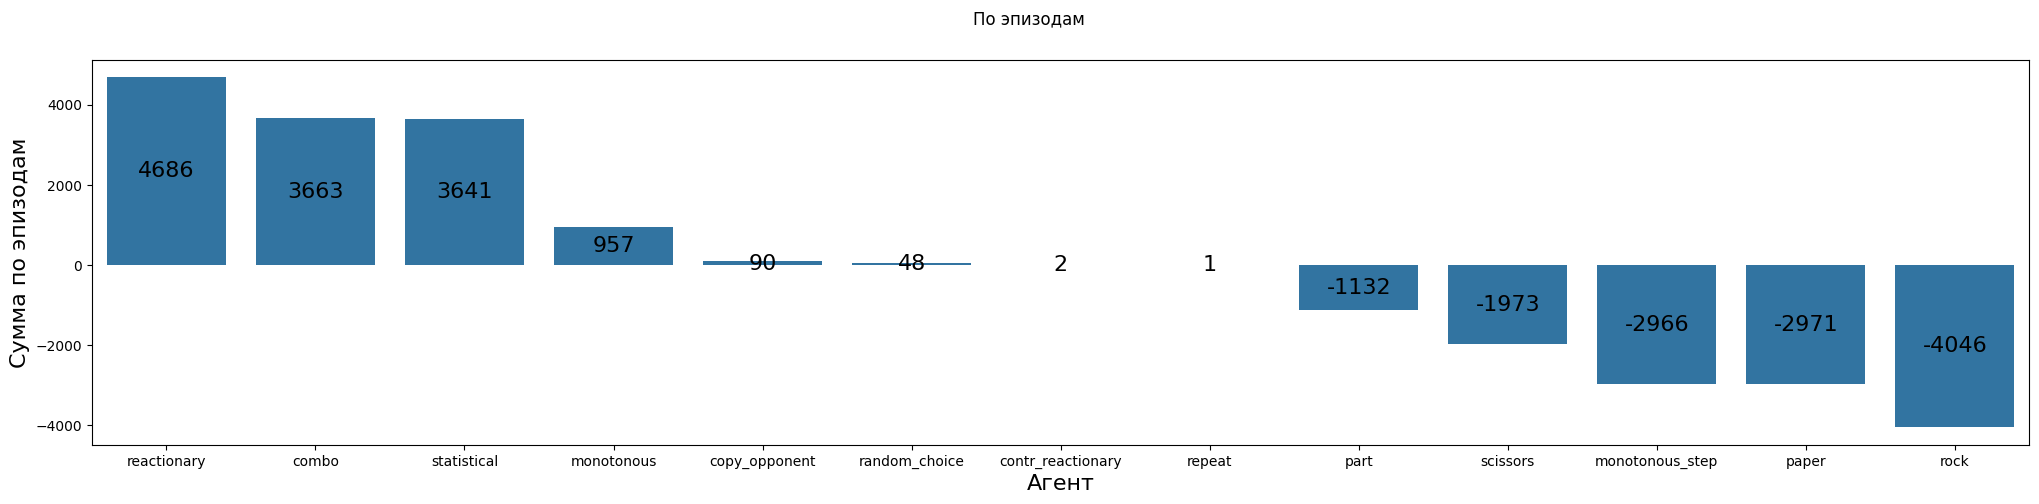

In [51]:
class Tournament:
    def __init__(self, agents):
        """
        :param dict agents: справочник агентов
        """

        # инициализируем атрибут со справочником агентов
        self.agents = agents
        # инициализируем справочник с результатами
        self.results = {}
        # для каждого ключа в справочнике агентов
        for agent in agents:
            # подготавливаем результат с 0 значением
            self.results[agent] = {'episodes_sum': 0, 'points': 0}

    # приватный метод для сохранения результатов раунда
    def __save_result(self, round_result, left, right):
        """
        Сохраняет результаты раунда.

        :param list round_result: результаты раунда
        :param str left: наименование левого агента
        :param str right: наименование правого агента
        """
        # сохраняем в переменную количество побед в ранде левого агента
        left_wins = round_result[0][0]
        # сохраняем в переменную количество побед в ранде левого агента
        right_wins = round_result[0][1]
        # добавляем победы левого агента в результаты
        self.results[left]['episodes_sum'] += left_wins
        # добавляем победы правого агента в результаты
        self.results[right]['episodes_sum'] += right_wins
        # если у левого агента больше побед
        if left_wins > right_wins:
            # добавляем в результаты 2 очка левому агенту
            self.results[left]['points'] += 2
        # если у правого агента больше побед
        elif left_wins < right_wins:
            # добавляем в результаты 2 очка правому агенту
            self.results[right]['points'] += 2
        # иначе ничья
        else:
            # добавляем в результаты 1 очко левому агенту
            self.results[left]['points'] += 1
            # добавляем в результаты 1 очко правому агенту
            self.results[right]['points'] += 1

    def start(self, episodes):
        """
        Метод запускает проведение турнира.

        :param int episodes: количество эпизодов в каждом раунде
        """
        # собираем список имен агентов
        names = list(self.agents.keys())

        # проводим раунды для всех возможных пар агентов
        # для числа i от 0 до количества агентов уменьшенного на 1
        # i будет представлять индекс левого агента в раунде
        for i in range(len(names) - 1):
            # для числа j от 0 до количества агентов уменьшенного на 1
            for j in range(len(names) - 1):
                # определяем индекс правого агента
                index = j + 1 + i
                # если вычисленный индекс превысил макимальный индекс
                if index > (len(names) - 1):
                    # выходим из цикла
                    break
                # сохраняем в переменную имя левого агента
                left = names[i]
                # сохраняем в переменную имя правого агента
                right = names[index]
                # проводим раунд и сохраняем результат в переменную
                round_result = evaluate(
                    "rps", #environment to use - no need to change
                    [agents[left], agents[right]], #agents to evaluate
                    configuration={"episodeSteps": episodes}, #episodes
                    debug=True
                )
                # сохраняем результат раунда
                self.__save_result(round_result, left, right)

    def print_result(self):
        """
        Отображает результаты турнира
        """
        # сортируем результат по полученным очкам
        sorted_table_p = dict(
            sorted(
                self.results.items(),
                key=lambda x: (x[1].get('points'), x[1].get('episodes_sum')),
                reverse=True
                )
            )
        # собираем список имен агентов в отсортированном порядке
        names_p = [name for name in sorted_table_p]
        # собираем список очков в отсортированном порядке
        points = [x[1].get('points') for x in sorted_table_p.items()]

        # создаем и отображаем график
        dfp = pd.DataFrame({"agent": names_p, "point": points})
        plt.figure(figsize=(25, 5))
        splot = sns.barplot(x="agent",y="point",data=dfp)
        plt.xlabel("Агент", size=16)
        plt.ylabel("Очки", size=16)
        plt.bar_label(splot.containers[0],size=16,label_type='center')
        plt.suptitle('По очкам')
        plt.show()

        # сортируем результат по сумме выигранных эпизодов
        sorted_table_e = dict(
            sorted(
                self.results.items(),
                key=lambda x: (x[1].get('episodes_sum'), x[1].get('points')),
                reverse=True
                )
            )
        # собираем список имен агентов в отсортированном порядке
        names_e = [name for name in sorted_table_e]
        # собираем список сумм выигранных эпизодов в отсортированном порядке
        ep_sum = [x[1].get('episodes_sum') for x in sorted_table_e.items()]

        # создаем и отображаем график
        dfe = pd.DataFrame({"agent": names_e, "win": ep_sum})
        plt.figure(figsize=(25, 5))
        splot=sns.barplot(x="agent",y="win",data=dfe)
        plt.xlabel("Агент", size=16)
        plt.ylabel("Сумма по эпизодам", size=16)
        plt.bar_label(splot.containers[0],size=16,label_type='center')
        plt.suptitle('По эпизодам')
        plt.show()


# создаем турнир, передав подготовленный справочник агентов
tournament = Tournament(agents)
# запускаем турнир, передав количество эпизодов в раунде
tournament.start(1000)
# отображаем результат турнира
tournament.print_result()